# **`Project 3: Team John Hicks`**

## **Mali** File

### **Objective**: Compare the nutritional intake and food intake in America vs. Mali before, during, and after the pandemic.

#### Group Members:
> Leona Katibah <br>
> Jack Pollard <br>
> Jakob Mackanych <br>
> Xi Wang <br>
> Wendy Peng <br>
> Sury Dongre
test


# Project Setup

In [2]:
#import all packages here
!pip install -r requirements.txt

In [3]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

In [82]:
uganda_Data = '1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w'

# **[A] Choice of a Population -  with supporting expenditure data**

- **Population chosen:** Households in **Mali** and in USA - but this document focuses only on the Mali data to maintain clarity across datasets.

- **Time periods:** Using data from **2014–15** (pre-COVID) and **2021–22** (post-COVID)
- **Reason for choice:** To explore how the COVID-19 pandemic impacted *food demand and consumption patterns*
- **Data available:** Detailed household-level data on *food expenditures, prices, and demographics*



### Function to Dynamically Select a **Year** (2013–14 or 2019–20) and get expenditure data


In [83]:
def process_data_per_year(uganda_data, year):
    """
    Processes the Uganda dataset for a given year.
    
    Parameters:
      uganda_data: The key or identifier for your Sheets data.
      year: The time period to filter by (e.g., "2013-14").
    
    Returns:
      x: DataFrame of processed food expenditures.
      p: DataFrame of processed food prices (only for goods with expenditures).
      y: DataFrame of the log of expenditures.
      d: DataFrame of household characteristics for the selected year.
    """
    # --- Food Expenditures ---
    sheet_expend = f"Food Expenditures ({year})"
    x = read_sheets(uganda_data, sheet=sheet_expend)
    x = x.set_index(['i', 't', 'm', 'j']).squeeze()
    
    # --- Food Prices ---
    sheet_prices = f"Food Prices ({year})"
    p = read_sheets(uganda_data, sheet=sheet_prices).set_index(['t', 'm', 'j', 'u'])
    p = p.groupby(['t', 'm', 'j', 'u']).median()
    
    # Inspect available unit values
    available_units = p.index.get_level_values('u').unique()
    print("Available unit values:", available_units)
    
    # Try to select prices with unit 'kg'
    try:
        p = p.xs('Kg', level="u").squeeze().unstack('j')
    except KeyError:
        # If 'kg' is not available, either adjust the unit or handle it differently:
        raise KeyError(f"'kg' not found in unit levels. Available units: {available_units}")
    
    p = p[x.index.levels[-1]].T

    # --- Household Characteristics ---
    d = read_sheets(uganda_data, sheet="Household Characteristics")
    d = d[d.t == year]
    d.columns.name = 'k'
    d = d.replace(np.nan, 0)
    
    # --- Expenditures Processing ---
    x = x.T.groupby(['i', 't', 'm', 'j']).sum()
    x = x.replace(0, np.nan)
    y = np.log(x)
    
    # --- Set index for household characteristics ---
    d.set_index(['i', 't', 'm'], inplace=True)
    
    return x, y, d


#Change Year (2013-14 or 2019-20) and Run Cell
x, y, d = process_data_per_year(Uganda_Data,"2019-20")

print("Food Expenditures (x)")
display(x.head())

print("Household Characteristics (d)")
display(d.head())

print("Log of Expenditures (y)")
display(y.head())

Available unit values: Index(['Kg', 'Tray of 30 eggs'], dtype='object', name='u')
Food Expenditures (x)


i                                 t        m         j              
0007d1f1449242feb5a25429644fb991  2019-20  Northern  Beans (dry)        12000
                                                     Beef               28000
                                                     Beer                9600
                                                     Cabbage (green)     1000
                                                     Cassava (fresh)     4000
Name: Expenditure, dtype: int64

Household Characteristics (d)


,,k,Females 00-03,Females 04-08,Females 09-13,Females 14-18,Females 19-30,Females 31-50,Females 51-99,Males 00-03,Males 04-08,Males 09-13,Males 14-18,Males 19-30,Males 31-50,Males 51-99,log HSize
i,t,m,,,,,,,,,,,,,,,
0007d1f1449242feb5a25429644fb991,2019-20,Northern,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.609438
0010cbae3cea4ec9831f6cd92b02dc16,2019-20,Northern,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.098612
00246782f8654441a9df0f6ec0b6fc9f,2019-20,Northern,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.791759
003ed8d32f794609919d60d2ed8813e8,2019-20,Eastern,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.386294
005fbc5779014a0290b088071bde9f72,2019-20,Central,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


Log of Expenditures (y)


i                                 t        m         j              
0007d1f1449242feb5a25429644fb991  2019-20  Northern  Beans (dry)         9.392662
                                                     Beef               10.239960
                                                     Beer                9.169518
                                                     Cabbage (green)     6.907755
                                                     Cassava (fresh)     8.294050
Name: Expenditure, dtype: float64

# **[B] Nutritional content of differnet foods**

In [97]:
sheet_id = '1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w'

InputFiles = {
    'Expenditures_2013-14': (sheet_id, 'Food Expenditures (2013-14)'),
    'Expenditures_2019-20': (sheet_id, 'Food Expenditures (2019-20)'),
    'Prices_2013-14': (sheet_id, 'Food Prices (2013-14)'),
    'Prices_2019-20': (sheet_id, 'Food Prices (2019-20)'),
    'HH_Characteristics': (sheet_id, 'Household Characteristics'),
    'FCT': (sheet_id, 'FCT'),
    'RDI': (sheet_id, 'RDI')
}


### Function to Dynamically Select a **Year** (2014–15 or 2021–22) and clean DFs

In [119]:
def load_nutritional_data(year):
    """
    Loads and cleans data for the specified year.
    
    Returns
    -------
    (x, z, p, fct, rdi) : tuple of pandas.DataFrames
        x: Expenditures data
        z: Household characteristics
        p: Prices data
        fct: Food Composition Table
        rdi: Recommended Daily Intake
    """
    # --- Expenditures ---
    x = get_clean_sheet(
        InputFiles[f"Expenditures_{year}"][0],
        sheet=InputFiles[f"Expenditures_{year}"][1]
    )
    if 'm' not in x.columns:
        x['m'] = 1
    x = x.set_index(['i', 't', 'm'])
    x.columns.name = 'j'
    x = x.apply(lambda col: pd.to_numeric(col, errors='coerce'))
    x = x.replace(0, np.nan)

    # --- Household Characteristics ---
    z = get_clean_sheet(
        InputFiles["HH_Characteristics"][0],
        sheet=InputFiles["HH_Characteristics"][1]
    )
    if 'm' not in z.columns:
        z['m'] = 1
    z = z.set_index(['i','t','m'])
    z.columns.name = 'k'
    z = z.apply(lambda col: pd.to_numeric(col, errors='coerce'))

    # --- Prices ---
    p = get_clean_sheet(
        InputFiles[f"Prices_{year}"][0],
        sheet=InputFiles[f"Prices_{year}"][1]
    )
    if 'm' not in p.columns:
        p['m'] = 1
    p = p.set_index(['t','m'])
    p.columns.name = 'j'
    p = p.apply(lambda col: pd.to_numeric(col, errors='coerce'))
    p = p.replace(0, np.nan)

    # --- Food Composition Table (FCT) ---
    fct = get_clean_sheet(
        InputFiles["FCT"][0],
        sheet=InputFiles["FCT"][1]
    )
    # Keep the default row index (whatever came from the sheet).
    # Name the columns "n" to indicate nutrients:
    fct.columns.name = 'n'
    fct = fct.apply(lambda col: pd.to_numeric(col, errors='coerce'))

    # --- Recommended Daily Intake (RDI) ---
    rdi = get_clean_sheet(
        InputFiles["RDI"][0],
        sheet=InputFiles["RDI"][1]
    )
    rdi = rdi.set_index('n')
    rdi.columns.name = 'k'

    # Print shapes (optional)
    print("Shape of x (Expenditures):", x.shape)
    print("Shape of z (Household Characteristics):", z.shape)
    print("Shape of p (Prices):", p.shape)
    print("Shape of fct (Food Composition Table):", fct.shape)
    print("Shape of rdi (Recommended Daily Intake):", rdi.shape)

    return x, z, p, fct, rdi

# ---------------------------------------------------------------------------
# CHOOSE YEAR):
# ---------------------------------------------------------------------------
x, z, p, fct, rdi = load_nutritional_data("2013-14")
display(x.head())
display(z.head())
display(p.head())
display(fct.head())
display(rdi.head())

Shape of x (Expenditures): (48969, 2)
Shape of z (Household Characteristics): (24363, 15)
Shape of p (Prices): (278, 3)
Shape of fct (Food Composition Table): (129, 21)
Shape of rdi (Recommended Daily Intake): (20, 14)


j                              j  Expenditure
i            t       m                       
H00101-04-01 2013-14 Central NaN       1500.0
                     Central NaN       1600.0
                     Central NaN       4000.0
                     Central NaN       7000.0
                     Central NaN         50.0

,,k,Females 00-03,Females 04-08,Females 09-13,Females 14-18,Females 19-30,Females 31-50,Females 51-99,Males 00-03,Males 04-08,Males 09-13,Males 14-18,Males 19-30,Males 31-50,Males 51-99,log HSize
i,t,m,,,,,,,,,,,,,,,
0007d1f1449242feb5a25429644fb991,2019-20,Northern,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,1.609438
0010cbae3cea4ec9831f6cd92b02dc16,2019-20,Northern,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.098612
00246782f8654441a9df0f6ec0b6fc9f,2019-20,Northern,1.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,1.791759
003ed8d32f794609919d60d2ed8813e8,2019-20,Eastern,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.386294
004e93d7552248ed95d8bc3ec21bdbdb,2018-19,Eastern,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.386294


j                 j   u        price
t       m                           
2013-14 Central NaN NaN  2362.934589
        Central NaN NaN   777.252959
        Central NaN NaN  2320.166666
        Central NaN NaN  4432.131012
        Central NaN NaN  7516.425121

n,index,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,...,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc,Magnesium,Phosphorus,Potassium,Vitamin E,Vitamin K
0,NaN,617.893,1.875,20.43,0,46.56,147.817,0.0,0.90,0.6625,...,0,0.0,0.2131,0,0.1964,46.95,91.83,953.1,0.0,0
1,NaN,1600.000,20.000,70.00,810,120.00,85.000,6.0,17.38,1.3000,...,70,0.0,2.5700,100,6.0000,0.00,0.00,0.0,0.0,0
2,NaN,1700.000,98.000,60.00,500,580.00,325.000,30.0,7.00,1.2000,...,0,0.0,2.1500,10,8.0000,0.00,0.00,0.0,0.0,0
3,NaN,3470.000,214.000,160.00,5250,1130.00,626.000,51.0,11.74,2.1200,...,0,0.0,4.7400,63,23.0000,0.00,0.00,0.0,0.0,0
4,NaN,2510.000,182.000,0.00,60,70.00,0.000,19.0,31.50,1.6000,...,0,28.9,3.8000,0,37.0000,0.00,0.00,0.0,0.0,0


k,F 00-03,M 00-03,F 04-08,M 04-08,F 09-13,M 09-13,F 14-18,M 14-18,F 19-30,M 19-30,F 31-50,M 31-50,F 51+,M 51+
n,,,,,,,,,,,,,,
Energy,1000.0,1000.0,1200.0,1400.0,1600.0,1800.0,1800.0,2200.0,2000.0,2400.0,1800.0,2200.0,1600.0,2000.0
Protein,13.0,13.0,19.0,19.0,34.0,34.0,46.0,52.0,46.0,56.0,46.0,56.0,46.0,56.0
Fiber,14.0,14.0,16.8,19.6,22.4,25.2,25.2,30.8,28.0,33.6,25.2,30.8,22.4,28.0
Folate,150.0,150.0,200.0,200.0,300.0,300.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
Calcium,700.0,700.0,1000.0,1000.0,1300.0,1300.0,1300.0,1300.0,1000.0,1000.0,1000.0,1000.0,1200.0,1000.0


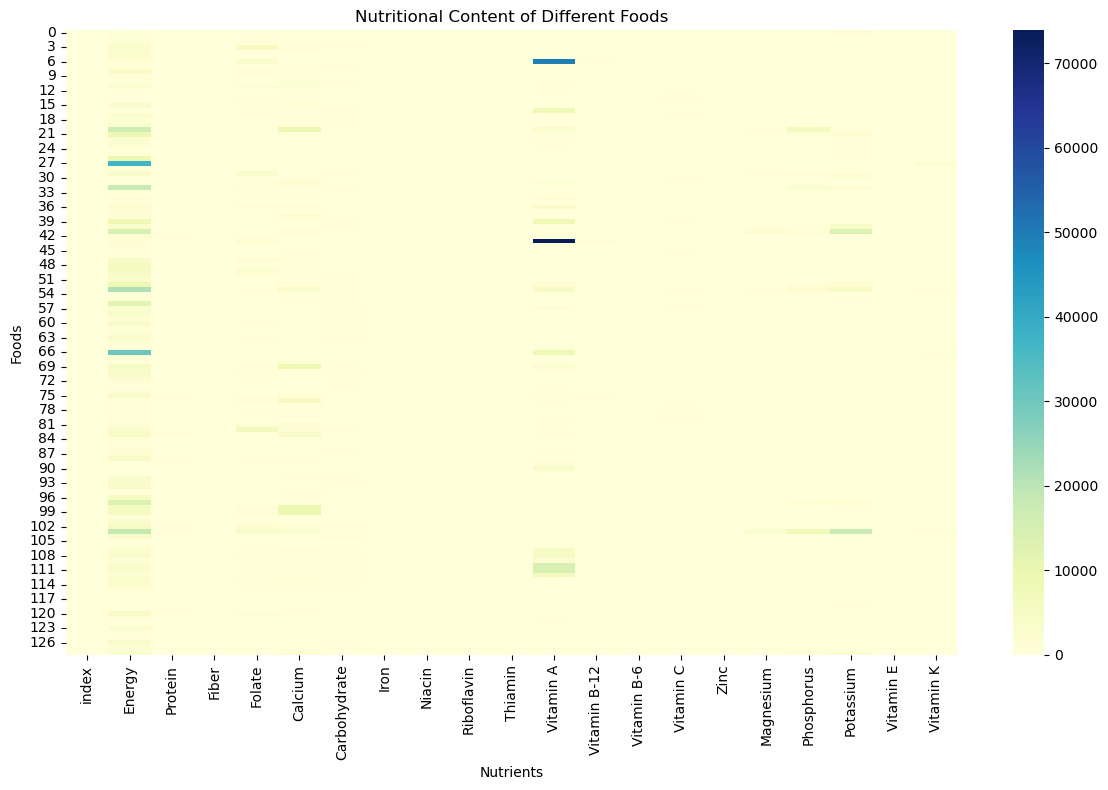

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_nutritional_heatmap(fct, title="Nutritional Content of Different Foods"):
    """
    Creates a heatmap of nutrient values (columns) across different foods (rows).

    Parameters
    ----------
    fct : pd.DataFrame
        Food Composition Table with foods as the row index and nutrients as columns.
    title : str
        Title of the heatmap.
    """
    # If you have a very large DataFrame, consider selecting a subset, e.g.:
    # fct = fct.iloc[:20, :]  # first 20 foods, for example

    # Convert any missing values to 0 or another placeholder for visualization
    fct_filled = fct.fillna(0)

    plt.figure(figsize=(12, 8))
    sns.heatmap(fct_filled, cmap="YlGnBu", annot=False)  # set annot=True to show actual values
    plt.title(title)
    plt.xlabel("Nutrients")
    plt.ylabel("Foods")
    plt.tight_layout()
    plt.show()

# Example usage (assuming your FCT DataFrame is named `fct`):
plot_nutritional_heatmap(fct)


#  **[B] Nutritional adequacy of diet** 

# **[A] Estimate Demand System**

In [30]:
def process_data_per_year(mali_data, year):
    """
    Processes the Mali dataset for a given year.
    
    Parameters:
      mali_data: The key or identifier for your Sheets data.
      year_str: The time period to filter by (e.g., "2021-22").
    
    Returns:
      x: DataFrame of processed food expenditures.
      p: DataFrame of processed food prices (only for goods with expenditures).
      y: DataFrame of the log of expenditures.
      d: DataFrame of household characteristics for the selected year.
    """
    # --- Food Expenditures ---
    sheet_expend = f"Food Expenditures ({year})"
    x = read_sheets(mali_data, sheet=sheet_expend)
    # Set multi-index and squeeze if possible (your code expects a Series)
    x = x.set_index(['i','t','m','j']).squeeze()
    
    # --- Food Prices ---
    sheet_prices = f"Food Prices ({year})"
    p = read_sheets(mali_data, sheet=sheet_prices).set_index(['t','m','j','u'])
    # Compute medians of prices for each time, place, good, and unit
    p = p.groupby(['t','m','j','u']).median()
    # Keep only metric units (e.g., 'kg')
    p = p.xs('kg', level="u").squeeze().unstack('j')
    # Drop prices for goods we don't have expenditures for
    p = p[x.index.levels[-1]].T

    # --- Household Characteristics ---
    d = read_sheets(mali_data, sheet="Household Characteristics")
    # Filter the data for the selected year
    d = d[d.t == year]
    # Set column names attribute and replace missing values with zeros
    d.columns.name = 'k'
    d = d.replace(np.nan, 0)
    
    # --- Expenditures Processing ---
    x = x.T.groupby(['i','t','m','j']).sum()
    x = x.replace(0, np.nan)
    # Take logarithms of expenditures; call this y
    y = np.log(x)
    
    # --- Set index for household characteristics ---
    d.set_index(['i','t','m'], inplace=True)
    
    return x, y, d

#Change Year ( 2014-15 or 2020-21) and Run Cell
x, y, d = process_data_per_year(Mali_Data, "2014-15")

print("Food Expenditures (x)")
display(x.head())

print("Household Characteristics (d)")
display(d.head())

print("Log of Expenditures (y)")
display(y.head())

Food Expenditures (x)


i     t        m      j                         
1003  2014-15  Kayes  Feuilles de Haricot            300
                      Feuilles de baobab             200
                      Thé en paquet ou en sachet     700
1006  2014-15  Kayes  Poisson fumé                  3500
                      Poisson séché                 1500
Name: expenditure, dtype: int64

Household Characteristics (d)


,,k,F 00-03,F 04-08,F 09-13,F 14-18,F 19-30,F 31-50,F 51+,M 00-03,M 04-08,M 09-13,M 14-18,M 19-30,M 31-50,M 51+,M NA,log HSize,F NA
i,t,m,,,,,,,,,,,,,,,,,
1003,2014-15,Kayes,0.0,1.0,0.0,0.0,2.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.197225,0.0
1006,2014-15,Kayes,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,2.708050,0.0
1009,2014-15,Kayes,4.0,2.0,2.0,1.0,7.0,2.0,1.0,1.0,3.0,3.0,1.0,2.0,5.0,0.0,0.0,3.526361,0.0
10003,2014-15,Kayes,1.0,0.0,1.0,3.0,1.0,1.0,1.0,0.0,1.0,2.0,0.0,2.0,0.0,1.0,0.0,2.639057,0.0
10006,2014-15,Kayes,2.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,2.484907,0.0


Log of Expenditures (y)


i     t        m      j                         
1003  2014-15  Kayes  Feuilles de Haricot           5.703782
                      Feuilles de baobab            5.298317
                      Thé en paquet ou en sachet    6.551080
1006  2014-15  Kayes  Poisson fumé                  8.160518
                      Poisson séché                 7.313220
Name: expenditure, dtype: float64

In [31]:
from cfe import Regression

result = Regression(y=y,d=d)

In [32]:
result.predicted_expenditures()

i        t        m       j                         
6003     2014-15  Kayes   Autres légumes en feuilles     538.467344
                          Beurre de karité               335.545298
                          Biscuit                        889.907491
                          Cigarette                     1774.031343
                          Citron                         509.389985
                                                           ...     
1070009  2014-15  Bamako  Sel                            193.562617
                          Thé en paquet ou en sachet    1766.672664
                          Tomate fraîche                1298.000225
                          Viande de bœuf                2833.916612
                          Viande de mouton              2092.984794
Length: 27945, dtype: float64

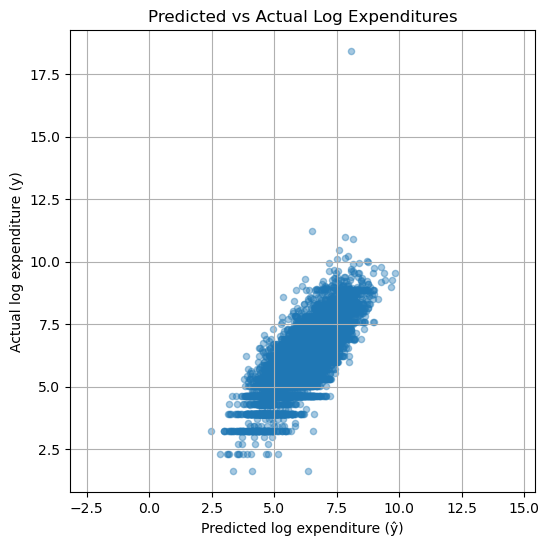

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

# Create DataFrame of actual vs predicted log expenditures
df = pd.DataFrame({
    'y': y,
    'yhat': result.get_predicted_log_expenditures()
})

# Drop missing values (some may not match if data was trimmed)
df = df.dropna()

# Plot
df.plot.scatter(x='yhat', y='y', alpha=0.4, figsize=(6, 6))
plt.title("Predicted vs Actual Log Expenditures")
plt.xlabel("Predicted log expenditure (ŷ)")
plt.ylabel("Actual log expenditure (y)")
plt.grid(True)
plt.axis("equal")  # force square axes
plt.show()

#### Parameters

##### (Relative) Income Elasticity


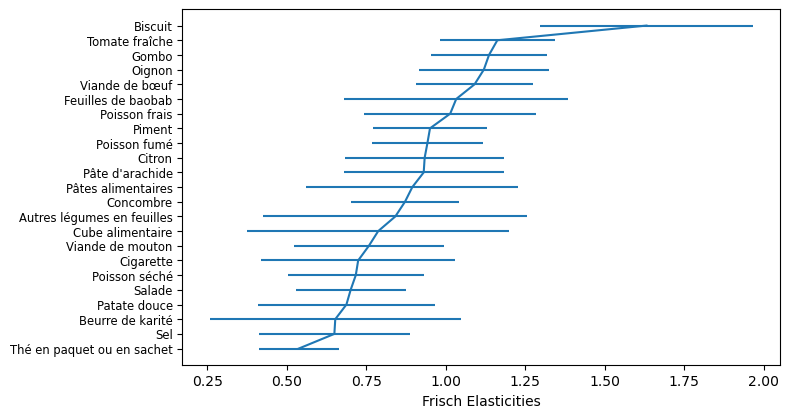

In [34]:
ax = result.graph_beta()

In [35]:
result.get_beta().sort_values

<bound method Series.sort_values of j
Autres légumes en feuilles    0.841831
Beurre de karité              0.652897
Biscuit                       1.631855
Cigarette                     0.724872
Citron                        0.934071
Concombre                     0.872178
Cube alimentaire              0.787910
Feuilles de baobab            1.033310
Gombo                         1.136520
Oignon                        1.120185
Patate douce                  0.687987
Piment                        0.950827
Poisson frais                 1.014420
Poisson fumé                  0.942790
Poisson séché                 0.717433
Pâte d'arachide               0.931074
Pâtes alimentaires            0.895276
Salade                        0.701279
Sel                           0.650041
Thé en paquet ou en sachet    0.537960
Tomate fraîche                1.162613
Viande de bœuf                1.091036
Viande de mouton              0.758657
Name: beta, dtype: float64>

In [36]:
result.get_gamma()

k,F 00-03,F 04-08,F 09-13,F 14-18,F 19-30,F 31-50,F 51+,M 00-03,M 04-08,M 09-13,M 14-18,M 19-30,M 31-50,M 51+,M NA,log HSize,F NA,Constant
j,,,,,,,,,,,,,,,,,,
Autres légumes en feuilles,-0.159067,-0.103195,-0.023572,0.048282,-0.017095,-0.058172,-0.077801,-0.206765,-0.045103,-0.050245,-0.143207,0.034196,0.253941,-0.039003,1.509014,0.523436,-0.347535,5.440711
Beurre de karité,-0.118888,-0.180389,0.091527,-0.103849,0.108534,0.114496,-0.039369,-0.279322,-0.065769,-0.161383,-0.001913,0.007227,-0.342393,-0.395767,-0.038907,0.806318,0.090886,5.252422
Biscuit,0.032509,0.095026,0.094203,0.016888,0.124792,-0.052659,0.107603,-0.145405,0.059901,0.094718,0.301008,-0.028899,-0.002660,0.084890,-0.461394,-0.439391,0.456273,5.767410
Cigarette,-0.024787,-0.114276,0.161815,0.182148,-0.005479,-0.044794,0.202749,0.005707,-0.088333,0.027520,0.119290,0.180961,0.179657,-0.436156,-0.050010,-0.436307,0.396480,6.751389
Citron,-0.034600,-0.134284,-0.016114,0.157905,-0.140526,-0.111361,-0.022024,-0.095258,0.001232,-0.000460,0.064648,0.039901,0.129519,-0.064849,0.334804,0.367144,-1.966000,5.270638
Concombre,-0.004899,-0.105107,0.011813,0.106436,0.057420,0.053585,-0.080522,-0.092365,0.008177,-0.031126,0.035344,0.003835,0.019599,-0.009476,0.373686,0.112805,-0.423368,6.040995
Cube alimentaire,0.317645,-0.116932,-0.074156,0.089159,0.018647,-0.035961,-0.069381,0.189510,0.025468,-0.041005,-0.017425,-0.000447,0.084888,0.292110,0.784457,-0.379131,-0.967355,6.456555
Feuilles de baobab,-0.314936,-0.114910,0.012987,0.022961,0.022176,-0.077477,-0.145036,0.100452,-0.065505,0.069935,-0.047582,0.025646,0.294231,0.231724,0.751423,0.514861,-0.035189,5.344325
Gombo,-0.026689,-0.038990,-0.031635,0.054300,0.002174,0.092018,0.060693,-0.057481,-0.012735,-0.056818,0.031093,0.020415,0.087967,-0.136468,1.069368,0.215856,-0.650894,6.090847


##### Welfare


<Axes: ylabel='Density'>

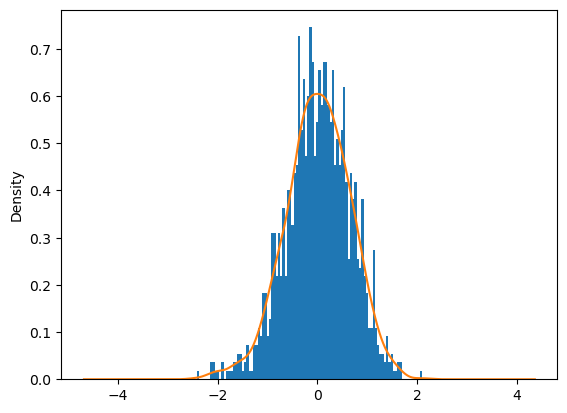

In [37]:
ax = result.get_w().plot.hist(bins=100,density=True)
result.get_w().plot.kde(ax=ax)

#### Saving Result

In [40]:
result.to_pickle('Mali_estimates.rgsn')

In [49]:
import cfe
result = cfe.regression.read_pickle('Mali_estimates.rgsn')


#### Demand and Utility


##### Budgets


In [50]:
xhat = result.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

##### Reference Prices


In [51]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.mean(axis=1)
pbar = pbar[result.beta.index] # Only use prices for goods we can estimate

# Replace missing prices with 1 (this is because they're best measured in expenditures)
pbar = pbar.replace(np.nan,1)

#Finally, define a function to change a single price in the vector $p$:
def my_prices(p0,j,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

KeyError: "['Cigarette', 'Feuilles de baobab', 'Poisson frais', 'Thé en paquet ou en sachet'] not in index"

##### Demand as a function of prices


##### Engel Curves


##### Indirect Utility


# [C] Counterfactual Experiments

In [ ]:
print("y_2 type:", type(x_2.stack()))
print("z_2 type:", type(z_2))
print("y_2 index names:", x_2.stack().index.names)
print("z_2 index names:", z_2.index.names)

In [ ]:
import cfe

result = cfe.Regression(y=np.log(x_2.stack()),d=z_2)

result.get_beta().sort_values(ascending=False)


# extra old code

In [78]:
def get_clean_sheet(key, sheet=None):
    
    df = read_sheets(key, sheet=sheet)
    df.columns = [c.strip() for c in df.columns]
    df = df.loc[:, ~df.columns.duplicated(keep='first')]
    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)
    df = df.loc[~df.index.duplicated(), :]
    return df

def load_data_by_year(year):
    """
    Dynamically loads and cleans data for a given year (e.g., '2014-15' or '2021-22').
    Returns x (expenditures), z (household characteristics),
    p (prices), fct (food composition), rdi (recommended dietary intake).
    """

    # 1) Expenditures
    x = get_clean_sheet(
        InputFiles[f'Expenditures_{year}'][0],
        sheet=InputFiles[f'Expenditures_{year}'][1]
    )
    if 'm' not in x.columns:
        x['m'] = 1
    x = x.set_index(['i', 't', 'm'])
    x.columns.name = 'j'
    x = x.apply(pd.to_numeric, errors='coerce').replace(0, np.nan)

    # 2) Household Characteristics (same key for all years)
    z = get_clean_sheet(
        InputFiles['HH_Characteristics'][0],
        sheet=InputFiles['HH_Characteristics'][1]
    )
    if 'm' not in z.columns:
        z['m'] = 1
    z = z.set_index(['i', 't', 'm'])
    z.columns.name = 'k'
    z = z.apply(pd.to_numeric, errors='coerce')

    # 3) Prices
    p = get_clean_sheet(
        InputFiles[f'Prices_{year}'][0],
        sheet=InputFiles[f'Prices_{year}'][1]
    )
    if 'm' not in p.columns:
        p['m'] = 1
    p = p.set_index(['t', 'm'])
    p.columns.name = 'j'
    p = p.apply(pd.to_numeric, errors='coerce').replace(0, np.nan)

    # 4) Food Composition Table (FCT) - not year-based
    fct = get_clean_sheet(
        InputFiles['FCT'][0],
        sheet=InputFiles['FCT'][1]
    )
    fct = fct.set_index('j')
    fct.columns.name = 'n'
    fct = fct.apply(pd.to_numeric, errors='coerce')

    # 5) Recommended Dietary Intake (RDI) - not year-based
    rdi = get_clean_sheet(
        InputFiles['RDI'][0],
        sheet=InputFiles['RDI'][1]
    )
    rdi = rdi.set_index('n')
    rdi.columns.name = 'k'

    return x_2, z_2, p_2, fct, rdi

year = '2021-22'  # SELECT '2014-15' OR '2021-22'

x_2, z_2, p_2, fct, rdi = load_data_by_year(year)

print(f"Expenditures for {year}:")
display(x.head())

print("Household Characteristics (z):")
display(z.head())

print(f"Prices for {year}:")
display(p.head())

print("FCT:")
display(fct.head())

print("RDI:")
display(rdi.head())


print("Shape of x (Expenditures):", x.shape)
print("Shape of z (Household Characteristics):", z.shape)
print("Shape of p (Prices):", p.shape)
print("Shape of fct (Food Composition Table):", fct.shape)
print("Shape of rdi (Recommended Daily Intake):", rdi.shape)

Expenditures for 2021-22:


j                        j  expenditure
i       t       m                      
1015001 2021-22 Bamako NaN          600
                Bamako NaN           50
                Bamako NaN          300
                Bamako NaN          300
                Bamako NaN         1100

Household Characteristics (z):


,,k,F 00-03,F 04-08,F 09-13,F 14-18,F 19-30,F 31-50,F 51+,M 00-03,M 04-08,M 09-13,M 14-18,M 19-30,M 31-50,M 51+,M NA,log HSize,F NA
i,t,m,,,,,,,,,,,,,,,,,
1001,2017-18,Kayes,NaN,2.0,1.0,NaN,2.0,NaN,NaN,1.0,2.0,NaN,NaN,NaN,1.0,NaN,NaN,2.197225,NaN
1002,2017-18,Kayes,3.0,NaN,NaN,2.0,2.0,1.0,NaN,NaN,1.0,NaN,NaN,1.0,1.0,1.0,NaN,2.484907,NaN
1003,2017-18,Kayes,NaN,3.0,4.0,4.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,NaN,NaN,NaN,3.135494,NaN
1004,2017-18,Kayes,6.0,3.0,5.0,6.0,5.0,4.0,1.0,2.0,6.0,3.0,1.0,3.0,3.0,1.0,NaN,3.891820,NaN
1005,2017-18,Kayes,1.0,3.0,1.0,4.0,2.0,3.0,2.0,NaN,2.0,1.0,2.0,1.0,NaN,1.0,NaN,3.135494,NaN


Prices for 2021-22:


j                j   u        price
t       m                          
2021-22 Bamako NaN NaN   228.774413
        Bamako NaN NaN  2985.054348
        Bamako NaN NaN   386.204562
        Bamako NaN NaN  1271.826923
        Bamako NaN NaN   290.770762

FCT:


n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
j,,,,,,,,,,,,,,,
Avocado,1600,20.0,70.0,810,120,85.0,6.0,17.38,1.30,0.67,70,0.0,2.57,100,6.0
Beans (dry),1700,98.0,60.0,500,580,325.0,30.0,7.00,1.20,3.40,0,0.0,2.15,10,8.0
Beans (fresh),3470,214.0,160.0,5250,1130,626.0,51.0,11.74,2.12,7.13,0,0.0,4.74,63,23.0
Beef,2510,182.0,0.0,60,70,0.0,19.0,31.50,1.60,0.90,0,28.9,3.80,0,37.0
Beef (roasted),2910,264.0,0.0,70,90,0.0,27.0,37.20,2.20,0.90,0,24.7,3.40,0,60.0


RDI:


k,F 00-03,M 00-03,F 04-08,M 04-08,F 09-13,M 09-13,F 14-18,M 14-18,F 19-30,M 19-30,F 31-50,M 31-50,F 51+,M 51+
n,,,,,,,,,,,,,,
Energy,1000.0,1000.0,1200.0,1400.0,1600.0,1800.0,1800.0,2200.0,2000.0,2400.0,1800.0,2200.0,1600.0,2000.0
Protein,13.0,13.0,19.0,19.0,34.0,34.0,46.0,52.0,46.0,56.0,46.0,56.0,46.0,56.0
Fiber,14.0,14.0,16.8,19.6,22.4,25.2,25.2,30.8,28.0,33.6,25.2,30.8,22.4,28.0
Folate,150.0,150.0,200.0,200.0,300.0,300.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
Calcium,700.0,700.0,1000.0,1000.0,1300.0,1300.0,1300.0,1300.0,1000.0,1000.0,1000.0,1000.0,1200.0,1000.0


Shape of x (Expenditures): (112505, 2)
Shape of z (Household Characteristics): (24939, 17)
Shape of p (Prices): (1007, 3)
Shape of fct (Food Composition Table): (103, 15)
Shape of rdi (Recommended Daily Intake): (20, 14)
